In [236]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import lazypredict
from datetime import datetime
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import plotly.express as px

In [237]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

In [238]:
df = pd.read_csv('breast_cancer_survival.csv')
df.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
0,42,FEMALE,0.95,2.15,0.01,-0.05,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,20-May-18,26-Aug-18,Alive
1,54,FEMALE,0.00,1.38,-0.50,-0.51,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,26-Apr-18,25-Jan-19,Dead
2,63,FEMALE,-0.52,1.76,-0.37,0.01,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Lumpectomy,24-Aug-18,08-Apr-20,Alive
3,78,FEMALE,-0.88,0.13,-0.37,0.13,I,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,16-Nov-18,28-Jul-20,Alive
4,42,FEMALE,0.23,1.75,-0.54,-0.39,II,Infiltrating Ductal Carcinoma,Positive,Positive,Positive,Lumpectomy,12-Dec-18,05-Jan-19,Alive


In [239]:
print(df.columns)
print(df.shape)

Index(['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4',
       'Tumour_Stage', 'Histology', 'ER status', 'PR status', 'HER2 status',
       'Surgery_type', 'Date_of_Surgery', 'Date_of_Last_Visit',
       'Patient_Status'],
      dtype='object')
(334, 15)


In [240]:
df_null=df.isna().sum()
df_null

Age                    0
Gender                 0
Protein1               0
Protein2               0
Protein3               0
Protein4               0
Tumour_Stage           0
Histology              0
ER status              0
PR status              0
HER2 status            0
Surgery_type           0
Date_of_Surgery        0
Date_of_Last_Visit    17
Patient_Status        13
dtype: int64

In [241]:
df_null = df[df['Date_of_Last_Visit'].isna() | df['Patient_Status'].isna()]
df_null.index.tolist()

[9,
 18,
 60,
 105,
 117,
 188,
 200,
 202,
 206,
 214,
 229,
 230,
 231,
 268,
 272,
 316,
 321]

So All the dates which don't have 'Date_of_Last_Visit' also don't have the record that if they survived or not . So that means we can drop those Columns and the coloumns where only last date is not mentioned we are going to replace that with the Date_of_Surgery  

In [242]:
list = [9,18,60,105,117,188,200,202,206,214,229,230,231,268,272,316,321]

In [243]:
df = df.drop(df.index[list])
df.shape

(317, 15)

In [244]:
df_null = df[df['Date_of_Last_Visit'].isna()]
list2=df_null.index.tolist()
print(list2)
df_null

[]


,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status


In [245]:
df['Histology'].value_counts()

Histology
Infiltrating Ductal Carcinoma     224
Infiltrating Lobular Carcinoma     81
Mucinous Carcinoma                 12
Name: count, dtype: int64

In [246]:
df['Surgery_type'].value_counts()

Surgery_type
Other                          97
Modified Radical Mastectomy    89
Lumpectomy                     66
Simple Mastectomy              65
Name: count, dtype: int64

### Data Visualization

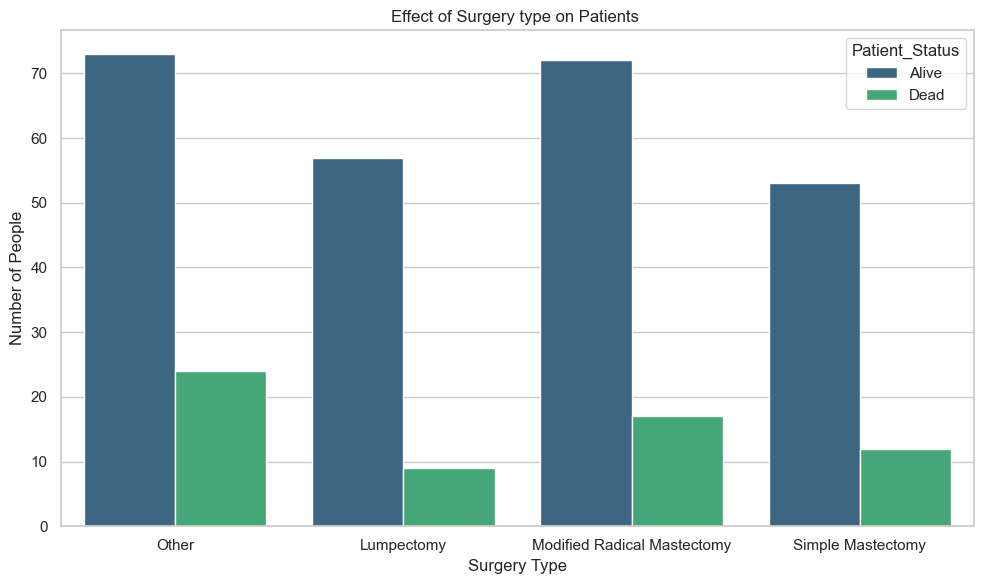

In [247]:
sn.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sn.countplot(x='Surgery_type', hue='Patient_Status', data=df,palette="viridis") 

plt.title('Effect of Surgery type on Patients ')
plt.xlabel('Surgery Type')
plt.ylabel('Number of People')
plt.tight_layout()
plt.show()

For , Surgery type we will use nominal Encoding beacuse for other and radical Masectomy the difference is not much(<5)much and the same is the reason for other two surgeries

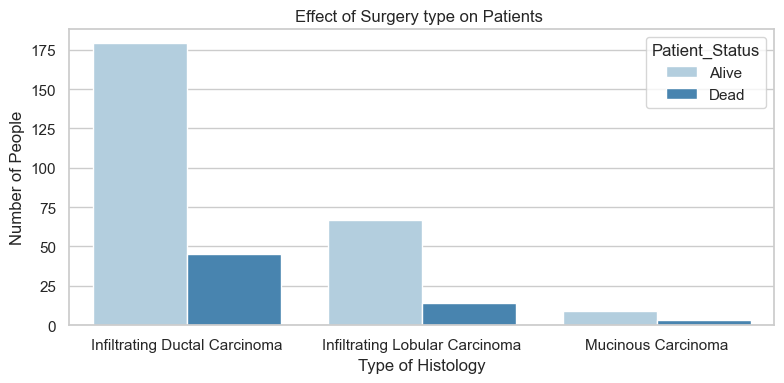

In [248]:
sn.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sn.countplot(x='Histology', hue='Patient_Status', data=df,palette="Blues") 

plt.title('Effect of Surgery type on Patients ')
plt.xlabel('Type of Histology')
plt.ylabel('Number of People')
plt.tight_layout()
plt.show()

Here the apporimiate ratio of first 2 is 0.23 . WE will use nominal Encoding

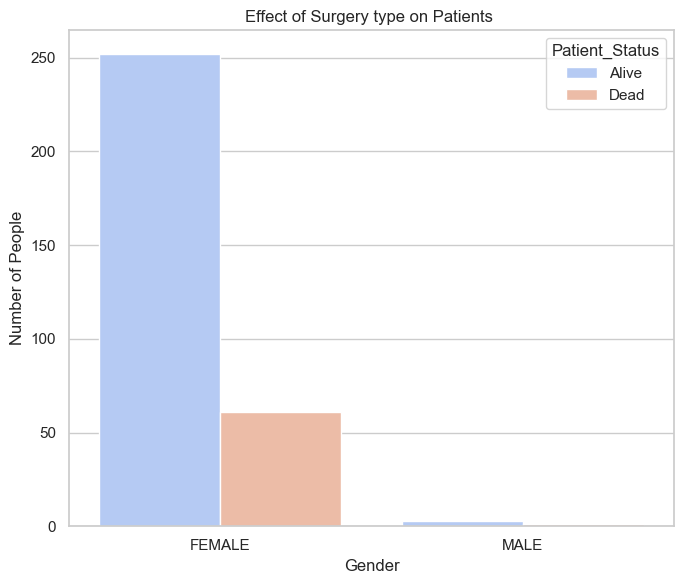

In [249]:
sn.set(style="whitegrid")

plt.figure(figsize=(7, 6))
sn.countplot(x='Gender', hue='Patient_Status', data=df,palette="coolwarm") 

plt.title('Effect of Surgery type on Patients ')
plt.xlabel('Gender')
plt.ylabel('Number of People')
plt.tight_layout()
plt.show()

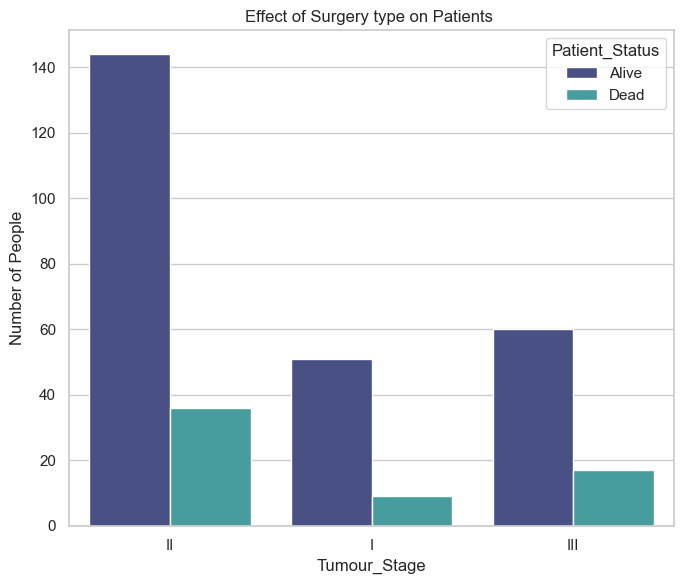

In [250]:
sn.set(style="whitegrid")

plt.figure(figsize=(7, 6))
sn.countplot(x='Tumour_Stage', hue='Patient_Status', data=df,palette="mako") 

plt.title('Effect of Surgery type on Patients ')
plt.xlabel('Tumour_Stage')
plt.ylabel('Number of People')
plt.tight_layout()
plt.show()

Now, the interesting thing to note here is the ratio = dead/total for Stage_2 is 0.22, Stage_1 is 0.16 and Stage_3 is 0.23
There is a very minor differences between them which can also be due to other factors we will do Nominal Encoding 

Text(0.5, 0, 'HER2 status')

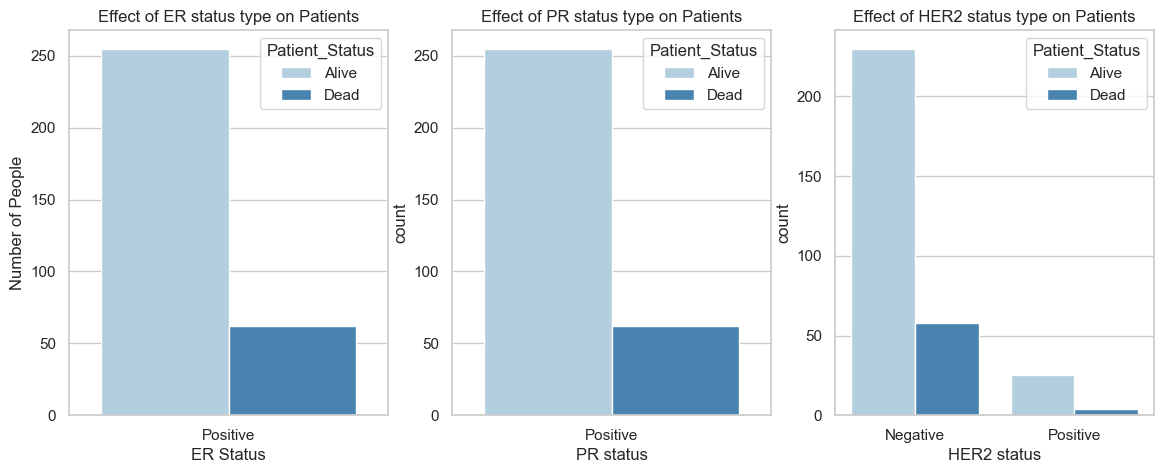

In [251]:


sn.set(style="whitegrid")

# Create a figure and two subplots side by side
fig, (ax1, ax2 , ax3) = plt.subplots(1, 3 , figsize=(14, 5))

# First subplot
sn.countplot(x='ER status', hue='Patient_Status', data=df, palette="Blues", ax=ax1)
ax1.set_title('Effect of ER status type on Patients')
ax1.set_xlabel('ER Status')
ax1.set_ylabel('Number of People')


# Second subplot
sn.countplot(x= 'PR status', hue='Patient_Status', data=df, palette="Blues", ax=ax2)
ax2.set_title('Effect of PR status type on Patients')
ax2.set_xlabel('PR status')


sn.countplot(x= 'HER2 status', hue='Patient_Status', data=df, palette="Blues", ax=ax3)
ax3.set_title('Effect of HER2 status type on Patients')
ax3.set_xlabel('HER2 status')


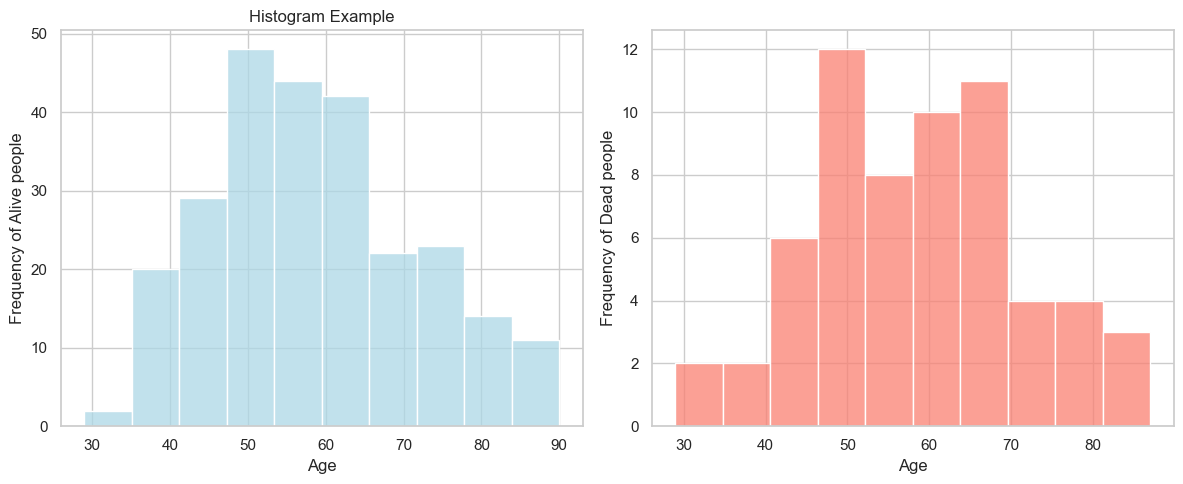

In [252]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
data1 = df[df['Patient_Status']=='Alive']['Age']
data2 = df[df['Patient_Status']=='Dead']['Age']
sn.histplot(data=data1, bins=10, kde=False, ax=ax1,color="lightblue")
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequency of Alive people')
ax1.set_title('Histogram Example')
sn.histplot(data=data2, bins=10, kde=False,color="salmon",ax=ax2)
ax2.set_ylabel('Frequency of Dead people')
plt.tight_layout()

So, we can drop the 'ER Status' and 'PR Status' coloumn because they only have one value and apply Nominal Encoding for HER2 Status

### Feature Engineering 

In [253]:
df2 = df

First we will drop the 

In [254]:
df2['Date_of_Surgery'] = pd.to_datetime(df['Date_of_Surgery'], format='%d-%b-%y')
df2['Date_of_Last_Visit'] = pd.to_datetime(df['Date_of_Last_Visit'], format='%d-%b-%y')
df2['Days'] = (df2['Date_of_Last_Visit']-df2['Date_of_Surgery']).dt.days

df2.tail()


,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status,Days
329,59,FEMALE,0.02,1.40,0.02,0.28,II,Infiltrating Ductal Carcinoma,Positive,Positive,Positive,Lumpectomy,2019-01-15,2020-03-27,Alive,437
330,41,FEMALE,0.10,-0.47,0.47,-0.52,I,Infiltrating Ductal Carcinoma,Positive,Positive,Positive,Modified Radical Mastectomy,2018-07-25,2019-04-23,Alive,272
331,54,FEMALE,0.75,1.64,-0.33,0.86,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Simple Mastectomy,2019-03-26,2019-10-11,Dead,199
332,74,FEMALE,0.97,1.43,-0.37,-0.11,II,Infiltrating Lobular Carcinoma,Positive,Positive,Negative,Lumpectomy,2018-11-26,2018-12-05,Alive,9
333,66,FEMALE,0.29,1.40,0.32,0.84,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,2019-02-04,2019-08-10,Dead,187


Text(0, 0.5, 'Days between First and Last Checkup')

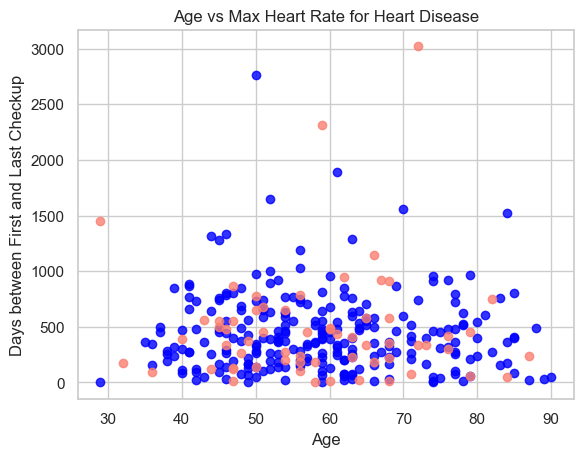

In [255]:
#Scatter with positive examples
plt.scatter(df2.Age[df.Patient_Status=="Alive"],
           df2.Days[df.Patient_Status=="Alive"],
           c="blue",alpha=0.8,label='Alive')

#Scatter with negative examples
plt.scatter(df2.Age[df.Patient_Status=="Dead"],
           df2.Days[df.Patient_Status=="Dead"],
           c="salmon",alpha=0.8,label='Dead')

plt.title("Age vs Max Heart Rate for Heart Disease")
plt.xlabel("Age")
plt.ylabel("Days between First and Last Checkup")

Here 2 points are showing negetive days that means we have 2 rows of wrong data So lets remove it.

Aso there are some Extreme outlier which represents that the Survived_status is not dependent on the given Features .


WE will only remove the outliers after the upper bound and not below the lower_bound because if you the the scater plot there are many values which lie within that 0.25 quantile range 

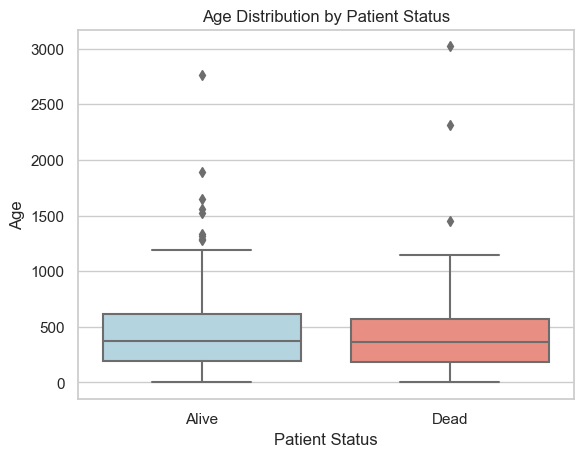

In [256]:
sn.boxplot(x=df2.Patient_Status, y=df2.Days, palette={"Alive": "lightblue", "Dead": "salmon"})
plt.title("Age Distribution by Patient Status")
plt.xlabel("Patient Status")
plt.ylabel("Age")

plt.show()

In [257]:
factor=1.5
Q1 = df2['Days'].quantile(0.25)
Q3 = df2['Days'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + factor * IQR


In [258]:
df2 = df2[df2['Days']<upper_bound]

Text(0, 0.5, 'Days between First and Last Checkup')

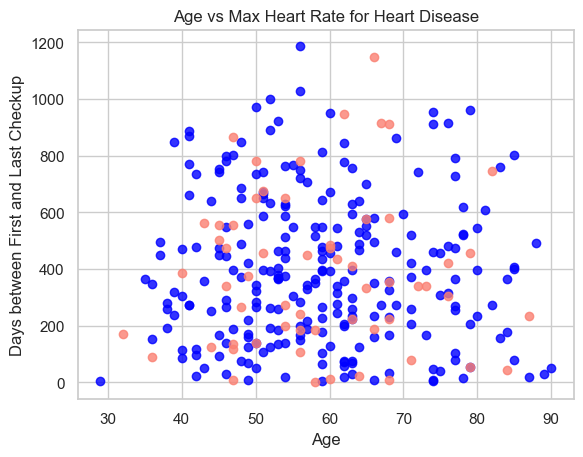

In [259]:
plt.scatter(df2.Age[df.Patient_Status=="Alive"],
           df2.Days[df.Patient_Status=="Alive"],
           c="blue",alpha=0.8,label='Alive')

#Scatter with negative examples
plt.scatter(df2.Age[df.Patient_Status=="Dead"],
           df2.Days[df.Patient_Status=="Dead"],
           c="salmon",alpha=0.8,label='Dead')

plt.title("Age vs Max Heart Rate for Heart Disease")
plt.xlabel("Age")
plt.ylabel("Days between First and Last Checkup")

In [260]:
columns_ = ['Histology', 'Tumour_Stage', 'Surgery_type','HER2 status','Gender','Patient_Status']
df2= pd.get_dummies(df, columns=columns_, drop_first=False)

In [261]:
df2.shape

(317, 26)

In [262]:
df2.columns

Index(['Age', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'ER status',
       'PR status', 'Date_of_Surgery', 'Date_of_Last_Visit', 'Days',
       'Histology_Infiltrating Ductal Carcinoma',
       'Histology_Infiltrating Lobular Carcinoma',
       'Histology_Mucinous Carcinoma', 'Tumour_Stage_I', 'Tumour_Stage_II',
       'Tumour_Stage_III', 'Surgery_type_Lumpectomy',
       'Surgery_type_Modified Radical Mastectomy', 'Surgery_type_Other',
       'Surgery_type_Simple Mastectomy', 'HER2 status_Negative',
       'HER2 status_Positive', 'Gender_FEMALE', 'Gender_MALE',
       'Patient_Status_Alive', 'Patient_Status_Dead'],
      dtype='object')

In [263]:
df2 = df2.drop(['ER status','PR status','Gender_MALE','Patient_Status_Dead','HER2 status_Negative','Date_of_Surgery','Date_of_Last_Visit','Histology_Mucinous Carcinoma','Tumour_Stage_III','Surgery_type_Simple Mastectomy'],axis=1)
df2.head()

,Age,Protein1,Protein2,Protein3,Protein4,Days,Histology_Infiltrating Ductal Carcinoma,Histology_Infiltrating Lobular Carcinoma,Tumour_Stage_I,Tumour_Stage_II,Surgery_type_Lumpectomy,Surgery_type_Modified Radical Mastectomy,Surgery_type_Other,HER2 status_Positive,Gender_FEMALE,Patient_Status_Alive
0,42,0.95,2.15,0.01,-0.05,98,True,False,False,True,False,False,True,False,True,True
1,54,0.00,1.38,-0.50,-0.51,274,True,False,False,True,False,False,True,False,True,False
2,63,-0.52,1.76,-0.37,0.01,593,True,False,False,True,True,False,False,False,True,True
3,78,-0.88,0.13,-0.37,0.13,620,True,False,True,False,False,False,True,False,True,True
4,42,0.23,1.75,-0.54,-0.39,24,True,False,False,True,True,False,False,True,True,True


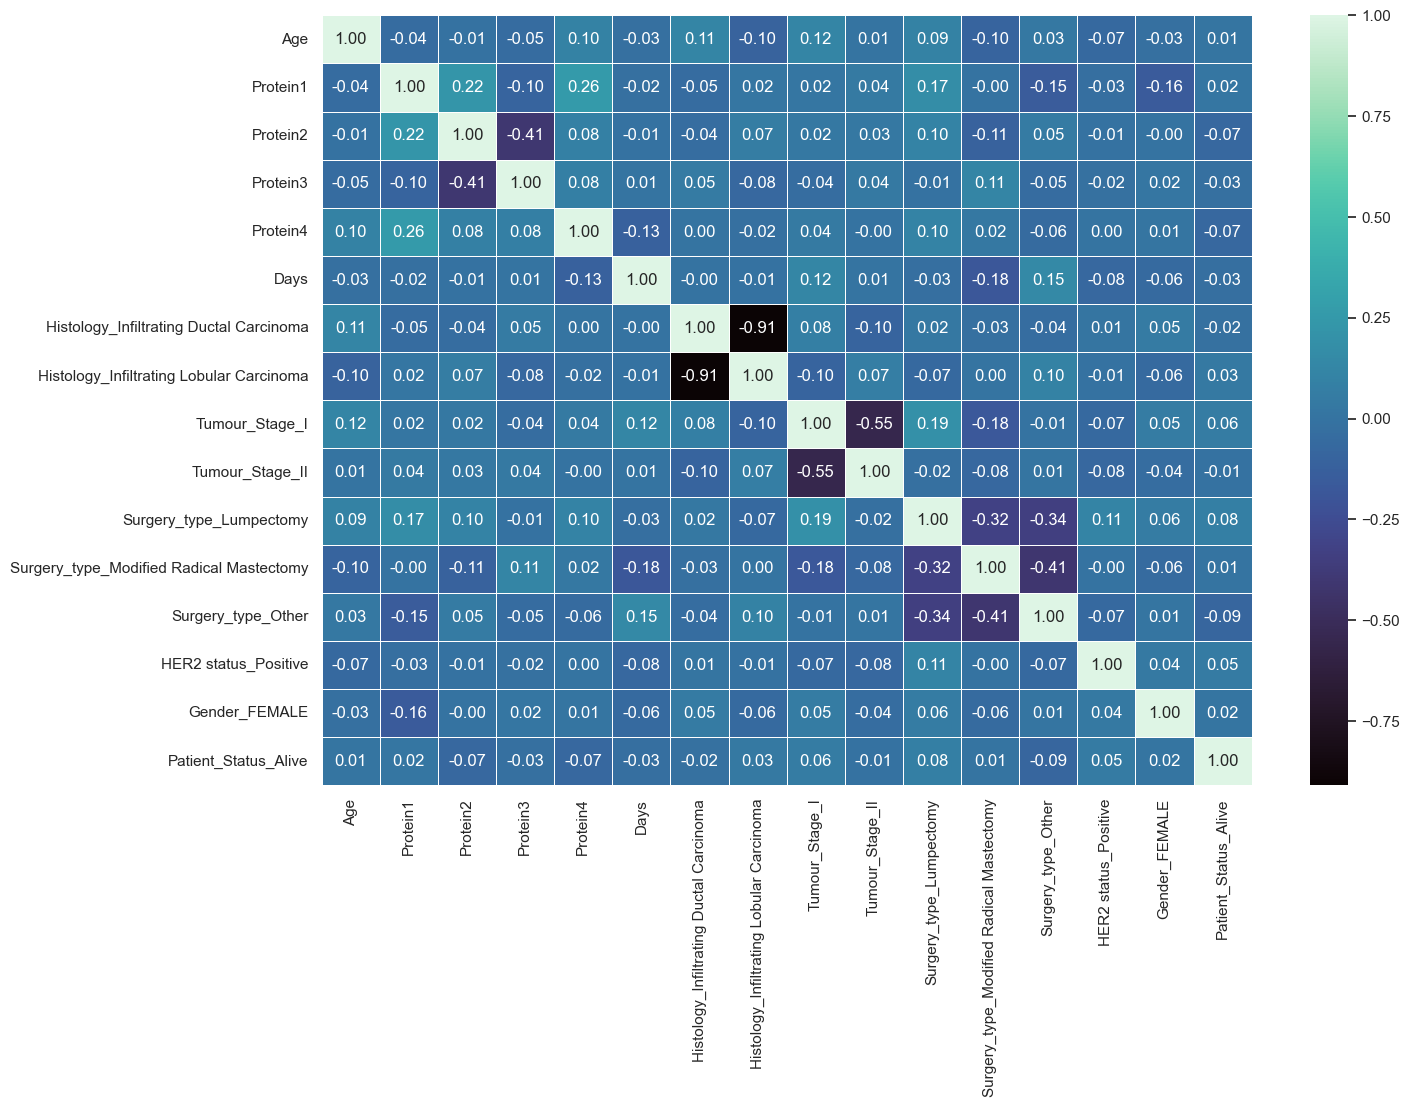

In [264]:
corr_matrix = df2.corr()
fig,ax = plt.subplots(figsize= (15,10))
ax= sn.heatmap(corr_matrix,
               annot=True,
               linewidths=0.5,
               fmt= ".2f",
               cmap="mako")

In [265]:

X = df2.drop(['Patient_Status_Alive'],axis=1)
y = df2['Patient_Status_Alive']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [266]:
df2.shape

(317, 16)

In [267]:
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

## Applying Machine Learning Models

> ## Using LazyClassifier

In [268]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_s, X_test_s, y_train, y_test)

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 30.43it/s]

[LightGBM] [Info] Number of positive: 170, number of negative: 42
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.801887 -> initscore=1.398129
[LightGBM] [Info] Start training from score 1.398129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [269]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score   
Model                                                                           
ExtraTreeClassifier                0.70               0.56     0.56      0.71  \
PassiveAggressiveClassifier        0.78               0.54     0.54      0.75   
KNeighborsClassifier               0.81               0.52     0.52      0.74   
AdaBoostClassifier                 0.74               0.52     0.52      0.72   
NearestCentroid                    0.54               0.51     0.51      0.59   
LabelSpreading                     0.69               0.50     0.50      0.69   
SVC                                0.81               0.50     0.50      0.72   
RidgeClassifierCV                  0.81               0.50     0.50      0.72   
RidgeClassifier                    0.81               0.50     0.50      0.72   
LogisticRegression                 0.81               0.50     0.50      0.72   
LinearSVC                   

> ### Using Cross Validation

In [270]:
def fit_and_score(models,X,y):
    model_scores = {}
    
    for name,model in models.items():
        cv1 = KFold(n_splits=5, shuffle=True, random_state=42)    
        cv1 = cross_val_score(model, X, y, cv=cv1, scoring='accuracy')
        cv1_mean_score = cv1.mean()
        model_scores[name] = cv1_mean_score   
    return model_scores

In [271]:
models= {"Logistic Regression": LogisticRegression(),
        "Random Forests": RandomForestClassifier(),
        "Support_Vector_Machine" : SVC()}

X = df2.drop('Patient_Status_Alive', axis=1)
y = df2['Patient_Status_Alive']

model_scores = fit_and_score(models, X, y)
model_scores

{'Logistic Regression': 0.8043650793650794,
 'Random Forests': 0.7981150793650793,
 'Support_Vector_Machine': 0.8011904761904762}

> ## Using HyperParameter Tuning


### Logistic Regression

In [272]:
param_grid={
 'class_weight' : [None,'balanced'],
  'penalty': ['l1', 'l2', 'elasticnet', None],
  'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag'],
  'max_iter': [80,100,200]
}

In [273]:
model=LogisticRegression()
cv=GridSearchCV(model,param_grid,cv=5,scoring='accuracy')
cv.fit(X_train_s,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_iter': [80, 100, 200],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag']},
             scoring='accuracy')

In [274]:
y_pred=cv.predict(X_test_s)
logistic_score=accuracy_score(y_pred,y_test)
logistic_score


0.8095238095238095

### K Nearest Neighbours

In [275]:
from sklearn.neighbors import KNeighborsClassifier
error_rate = []

for i in range(1,30):

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_s,y_train)
    y_pred = knn.predict(X_test_s)
    error_rate.append(np.mean(y_pred!=y_test))

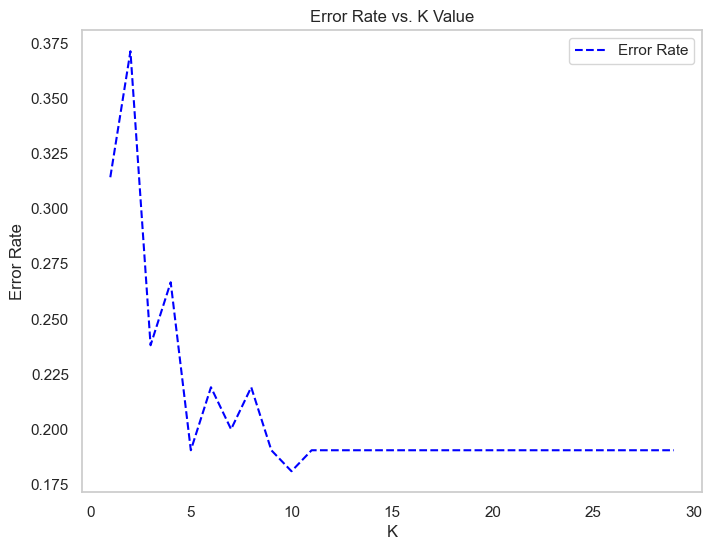

In [276]:
x_val = range(1, 30)
y_val = error_rate

plt.figure(figsize=(8, 6))
plt.plot(x_val, y_val, color='blue', linestyle='--', label='Error Rate')
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.legend()
plt.grid()

In [277]:

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_s,y_train)
y_pred = knn.predict(X_test_s)
KNN_score = accuracy_score(y_test, y_pred)
KNN_score

0.819047619047619

### Decision Trees

In [278]:
param_grid={
 'criterion':['gini','entropy','log_loss'],
  'splitter':['best','random'],
  'max_depth':[1,2,3,4,5],
  'max_features':['sqrt', 'log2',"auto"]
}

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
cv = GridSearchCV(model,param_grid,cv=5,scoring='accuracy')
cv.fit(X_train,y_train)
y_pred=cv.predict(X_test)
Decision_Tree_score=accuracy_score(y_pred,y_test)
Decision_Tree_score

0.7904761904761904

In [279]:
cv.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'splitter': 'best'}

Best Parameters for {'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'sqrt',
 'splitter': 'random'}

### Random Forests

In [280]:

rf_grid = {"n_estimators": np.arange(0,50,5),
          "max_depth": [None,3,5,10],
          "min_samples_split":np.arange(2,20,2),
            "min_samples_leaf": np.arange(1,20,2)}

In [281]:

model_ = RandomForestClassifier()
cv= RandomizedSearchCV(model_,rf_grid,cv=5,n_iter=10)

cv.fit(X_train,y_train)
y_pred_r = cv.predict(X_test)
rf_score = accuracy_score(y_pred_r,y_test)
rf_score

0.8095238095238095

In [282]:
cv.best_params_

{'n_estimators': 25,
 'min_samples_split': 12,
 'min_samples_leaf': 13,
 'max_depth': 3}

In [283]:
{'n_estimators': 10,
 'min_samples_split': 16,
 'min_samples_leaf': 9,
 'max_depth': None}
 #0.8529411764705882

{'n_estimators': 10,
 'min_samples_split': 16,
 'min_samples_leaf': 9,
 'max_depth': None}

### Support Vector Machines 

In [284]:
param_grid = {'C': np.arange(0,2,0.2),
              'gamma': ['scale', 'auto'] ,
              'kernel': ['rbf','sigmoid'],
              'degree': [2,3,4,5,6,7,8,9] 
              }
              
model_ = SVC()
cv = RandomizedSearchCV(model_,param_grid,cv=5,n_iter=10,scoring='accuracy')
cv.fit(X_train,y_train)
y_pred=cv.predict(X_test)

SVC_Score=accuracy_score(y_pred,y_test)
SVC_Score

0.8095238095238095

In [285]:
cv.best_params_

{'kernel': 'sigmoid', 'gamma': 'auto', 'degree': 4, 'C': 0.6000000000000001}

In [286]:
#{'kernel': 'rbf', 'gamma': 'scale','degree': 2, 'C': 0.8} : This gives an accuracy pf 0.8529

In [287]:
model = SVC(kernel = 'rbf',
            gamma = "scale",
            C= 0.8,
            degree = 2
)
model.fit(X_train,y_train)
y_pred_s=model.predict(X_test)

SVC_Score=accuracy_score(y_pred_s,y_test)
SVC_Score

0.8095238095238095

### Comparing the Accuracies of every Model

In [288]:
print("Accuracy with Logistic Regression : ",logistic_score)
print("\n")
print("Accuracy with K Nearest Neighbours Classification: ",KNN_score)
print("\n")
print("Accuracy with Decision Trees : ",Decision_Tree_score)
print("\n")
print("Accuracy with Random Forests  : ",rf_score)
print("\n")
print("Accuracy with Support Vector Machines : ",SVC_Score)

Accuracy with Logistic Regression :  0.8095238095238095


Accuracy with K Nearest Neighbours Classification:  0.819047619047619


Accuracy with Decision Trees :  0.7904761904761904


Accuracy with Random Forests  :  0.8095238095238095


Accuracy with Support Vector Machines :  0.8095238095238095


In [289]:
report = classification_report(y_test, y_pred_s)
print(report)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        20
        True       0.81      1.00      0.89        85

    accuracy                           0.81       105
   macro avg       0.40      0.50      0.45       105
weighted avg       0.66      0.81      0.72       105

[[ 0 20]
 [ 0 85]]
